In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
import datetime 
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import risk_opt_2Student as riskopt 

def tracking_error(wts_active,cov):
    TE = np.sqrt(np.transpose(wts_active)@cov@wts_active)
    return TE

# function to get the price data from yahoo finance 
def getDataBatch(tickers, startdate, enddate):
    def getData(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map(getData, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date'],sort=False))


In [2]:
if __name__ == "__main__":
    
    TickerNWeights = pd.read_excel('TICKER.xlsx', sheet_name='Index', header=0, index_col=0)
    Ticker_AllStock = TickerNWeights['Ticker']
    wts_AllStock = TickerNWeights['Weight']

    start_dt = datetime.datetime(1996, 1, 1)
    end_dt = datetime.datetime(2019, 1, 1)
    
    start_dt_training = datetime.datetime(1996, 1, 1)
    end_dt_training_p1 = datetime.datetime(2006, 1, 1)
    start_dt_test_p1 = datetime.datetime(2006, 1, 2)
    end_dt_test_p1 = datetime.datetime(2012, 1, 1)
    
    end_dt_training_p2 = datetime.datetime(2012,1,1)
    start_dt_test_p2 = datetime.datetime(2012,1,2)
    end_dt_test_p2 = datetime.datetime(2019, 1, 1)
    
    lamda = 0.94
    
    Flag_downloadData = False    
    if Flag_downloadData:
        stock_data = getDataBatch(Ticker_AllStock, start_dt, end_dt)
         # Isolate the `Adj Close` values and transform the DataFrame
        Price_AllStock=stock_data.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
        Price_AllStock=Price_AllStock[list(Ticker_AllStock)]
         # Create a Pandas Excel writer using XlsxWriter as the engine.
        Price_AllStock.to_excel('IndexPrice.xlsx', sheet_name='AllStockPrice')
    else:
        Price_AllStock=pd.read_excel('IndexPrice.xlsx',sheet_name='AllStockPrice', header=0, index_col=0)

# # All Stock Weighted Price

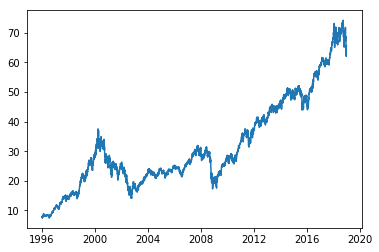

In [28]:
    ret_AllStock = Price_AllStock.pct_change().dropna()
    ret_Idx = np.dot(ret_AllStock,wts_AllStock)
    
    date=ret_AllStock.index.values
    ret_Idx=pd.DataFrame(ret_Idx)
    ret_Idx.index=date
    ret_Idx.columns=['DailyReturn']
    
    # Scale return data by a factor. It seems that the optimizer fails when the values are too close to 0
    scale = 1
    ret_AllStock = ret_AllStock*scale
    ret_Idx = ret_Idx*scale
    
    num_periods, num_stock = ret_AllStock.shape
    
    weight_price=np.dot(Price_AllStock[0:len(ret_AllStock)],wts_AllStock)
    plt.plot(date,weight_price)
    plt.show()

# Period_1

## Period 1 stock weighted price

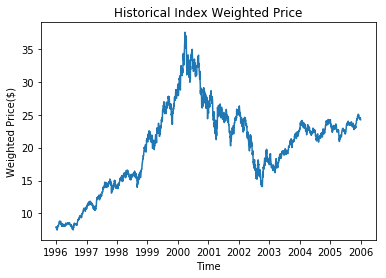

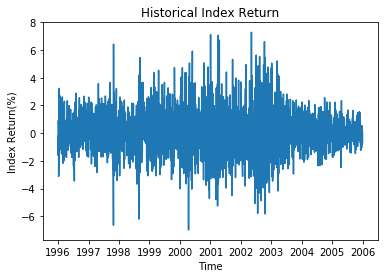

In [4]:
    ret_AllStock_p1 = ret_AllStock.loc[start_dt_training:end_dt_training_p1,:]
    ret_Idx_p1 = np.dot(ret_AllStock_p1,wts_AllStock)
    
    date=ret_AllStock_p1.index.values
    ret_Idx_p1=pd.DataFrame(ret_Idx_p1)
    ret_Idx_p1.index=date
    ret_Idx_p1.columns=['DailyReturn']
    
    # Scale return data by a factor. It seems that the optimizer fails when the values are too close to 0
    scale = 1
    ret_AllStock_p1 = ret_AllStock_p1*scale
    ret_Idx_p1 = ret_Idx_p1*scale

    num_periods, num_stock = ret_AllStock_p1.shape
    
    weight_price=np.dot(Price_AllStock[0:len(ret_AllStock_p1)],wts_AllStock)
    plt.plot(date,weight_price)
    plt.xlabel('Time')
    plt.ylabel('Weighted Price($)')
    plt.title('Historical Index Weighted Price')
    plt.show()
    
    plt.plot(date, ret_Idx_p1*100)
    plt.xlabel('Time')
    plt.ylabel('Index Return(%)')
    plt.title('Historical Index Return')
    plt.show()


## Covariance Matrix

In [5]:
    vols_p1 = ret_AllStock_p1.std()
    rets_mean_p1 = ret_AllStock_p1.mean()
    # demean the returns
    ret_AllStock_p1 = ret_AllStock_p1 - rets_mean_p1   
    # var_ewma calculation of the covraiance using the function from module risk_opt.py
    var_ewma_p1 = riskopt.ewma_cov(ret_AllStock_p1, lamda)
    #var_ewma_annual = var_ewma*252 #Annualize
    # take only the covariance matrix for the last date, which is the forecast for next time period
    cov_end_p1 = var_ewma_p1[-1,:]
    #
    cov_end_annual_p1 = cov_end_p1*252 #Annualize
    std_end_annual_p1 = np.sqrt(np.diag(cov_end_p1))*np.sqrt(252)
    # calculate the correlation matrix
    corr_p1 = ret_AllStock_p1.corr()
    

## Get Optimized Number of Assets

<Figure size 432x288 with 0 Axes>

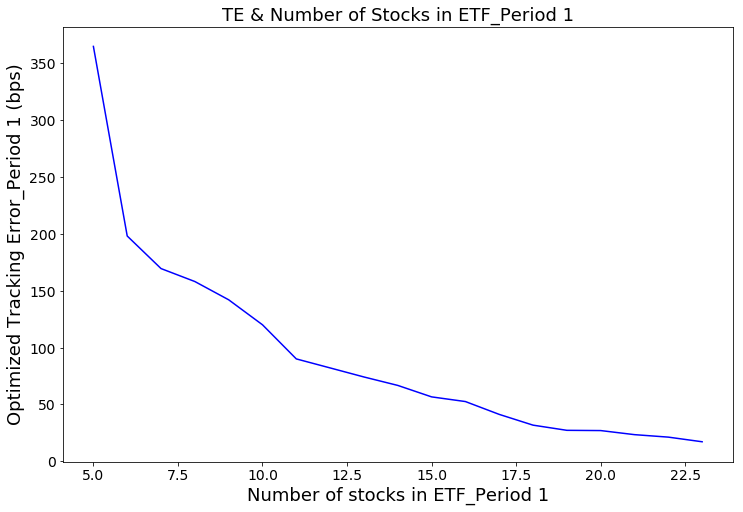

In [29]:
    num_stock_b = 5
    num_stock_e = 24
    numstock_2use_p1 = range(num_stock_b,num_stock_e)
    wts_active_hist_p1 = np.zeros([len(numstock_2use_p1), num_stock])
    TE_hist_p1 = np.zeros([len(numstock_2use_p1), 1])
    count = 0

    for i in numstock_2use_p1:
        # only the top weight stocks + no shorting 
        b1_c_a_ = [(0.0,1.0) for j in range(i)] 
        # exclude bottom weighted stocks
        b1_c_b_ = [(0.0,0.0) for j in range(i,num_stock)] 
        b1_curr_ = b1_c_a_ + b1_c_b_
        c1_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) 
        wts_min_curr_p1 = riskopt.opt_min_te(wts_AllStock, cov_end_annual_p1, b1_curr_, c1_)
#        print(wts_min_curr)
        
        wts_active_hist_p1[count,:] = wts_min_curr_p1.transpose()
        TE_optimized_c_p1 = tracking_error(wts_min_curr_p1-wts_AllStock,cov_end_annual_p1)
        TE_hist_p1[count,:] = TE_optimized_c_p1*10000# in bps
        count = count+1
        
        del b1_curr_, b1_c_a_, b1_c_b_,TE_optimized_c_p1,wts_min_curr_p1
    
    figure_count = 1
    plt.figure(figure_count)
    figure_count = figure_count+1
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(range(num_stock_b,num_stock_e), TE_hist_p1,'b')
    plt.xlabel('Number of stocks in ETF_Period 1', fontsize=18)
    plt.ylabel('Optimized Tracking Error_Period 1 (bps)', fontsize=18)
    plt.title('TE & Number of Stocks in ETF_Period 1', fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    

## Find Stock to be Add to ETF

In [7]:
    corr_stock_index_p1=np.zeros((5,2))
    for i in range(10,15):
        xdata=ret_Idx_p1.iloc[:,0]
        ydata=ret_AllStock_p1.iloc[:,i]
        corr=np.corrcoef(xdata, ydata)
        corr_stock_index_p1[i-10,0]=i
        corr_stock_index_p1[i-10,1]=corr[0,1]
#        corr_stock_index.iloc[i,0]=np.correlate(xdata,ydata)
    print(corr_stock_index_p1)
    
    num_stock_add_p1=[]
    for i in range(0,5):
        if corr_stock_index_p1[i,1]>0.50:
            num_stock_add_p1.append(corr_stock_index_p1[i,0])
    
    Ticker_ETF_p1=[]
    for i in range(1,10):
        Ticker_ETF_p1.append(Ticker_AllStock[i])
    for i in range(0,len(num_stock_add_p1)):
        j=num_stock_add_p1[i]
        Ticker_ETF_p1.append(Ticker_AllStock[j])

[[10.          0.56732957]
 [11.          0.57984436]
 [12.          0.35500748]
 [13.          0.4377201 ]
 [14.          0.30352503]]


## Traning & Testing 

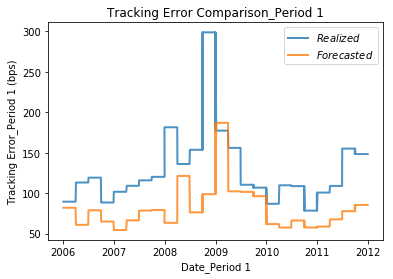

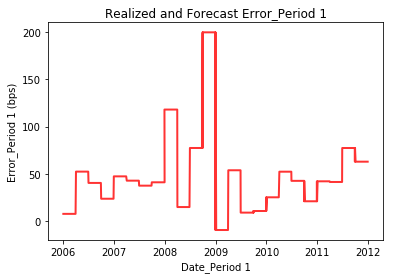

<Figure size 432x288 with 0 Axes>

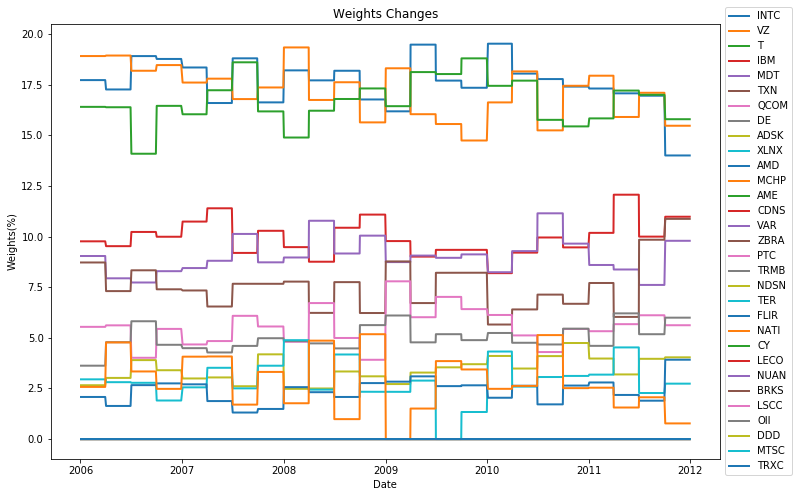

Text(0.5, 1.0, 'Optimized Weight_Period 1')

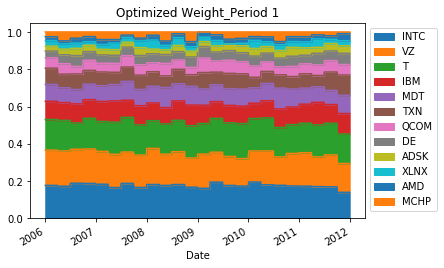

In [20]:
    # Calulate Covariance Matrix
    window = 90
    ret_AllStock_total_p1 = ret_AllStock.loc[start_dt_training:end_dt_test_p1,:] # both training and test data for period 1
    datestr_p1 = ret_AllStock_total_p1.index[ret_AllStock_total_p1.index>=start_dt_test_p1]
    qth_previous = datestr_p1[0]-timedelta(days=window)
    wts1 = pd.DataFrame(index=datestr_p1, columns=ret_AllStock_p1.columns)
    
    TE_optimized_All_p1={}
    TE_realized_All_p1={}
    t_begin = start_dt_test_p1
    
    
    
    for t in datestr_p1:
        if t.quarter!=qth_previous:

            # update the value of the previous month 
            qth_previous = t.quarter
            # re-balance the portfolio at the start of the month

            ret_used_AllStock = ret_AllStock.loc[start_dt_training:t_begin,:]
            
            t_end_test=t_begin+timedelta(days=window)
            ret_used_test = ret_AllStock.loc[t_begin:t_end_test,:]
            
            vols_used_AllStock = ret_used_AllStock.std()
            rets_used_mean_AllStock = ret_used_AllStock.mean()
            ret_used_AllStock = ret_used_AllStock - rets_used_mean_AllStock
            
            cov_end_realized = ret_used_test.cov()
            cov_end_realized = cov_end_realized.values
            cov_end_annual_realized = cov_end_realized * 252
            # var_ewma calculation of the covraiance using the function from module risk_opt.py
            var_ewma = riskopt.ewma_cov(ret_used_AllStock, lamda)
            #var_ewma_annual = var_ewma*252 #Annualize
            # take only the covariance matrix for the last date, which is the forecast for next time period
            cov_end_ewma = var_ewma[-1,:]
            #
            cov_end_annual_ewma = cov_end_ewma * 252#Annualize
            std_end_annual_ewma = np.sqrt(np.diag(cov_end_ewma))*np.sqrt(252)
            corr_used_AllStock = ret_used_AllStock.corr()
            
            # calling the optimization function
            b1a_ = [(0.0,1.0) for i in range(0,12)]
            b1b_ = [(0.0,0.0) for i in range(12,num_stock)]
            

            b_ = b1a_+b1b_
            c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })            
            wts_min_trackingerror = riskopt.opt_min_te(wts_AllStock, cov_end_annual_ewma, b_, c_)
            wts_slice=pd.DataFrame(wts_min_trackingerror,Ticker_AllStock)
            wts_slice=wts_slice.T
            wts1.loc[t]=wts_slice.values
            
            # calc TE achieved
            wts_active1 = wts_min_trackingerror - wts_AllStock
            TE_optimized = tracking_error(wts_active1,cov_end_annual_ewma)
            TE_realized = tracking_error(wts_active1, cov_end_annual_realized)
            TE_optimized_All_p1[t_begin] = TE_optimized
            TE_realized_All_p1[t_begin] = TE_realized
            
            t_begin = t + timedelta(days=window)
#            print(t_begin)
            
            del corr_used_AllStock, wts_slice
                    
        else:
            # keep the same portfolio weights within the month
            wts1.loc[t] = wts1.iloc[wts1.index.get_loc(t)-1]
            TE_optimized_All_p1[t] = TE_optimized
            TE_realized_All_p1[t] = TE_realized
                
    
    TE_optimized_All_p1 = pd.DataFrame(TE_optimized_All_p1, index=[0])
    TE_optimized_All_p1 = TE_optimized_All_p1.T
    TE_optimized_All_p1.columns = ['TE_optimized']

    TE_realized_All_p1 = pd.DataFrame(TE_realized_All_p1, index=[0])
    TE_realized_All_p1 = TE_realized_All_p1.T
    TE_realized_All_p1.colums = ['TE_realiezed']
    
    #%%
    date_p1=TE_optimized_All_p1.index
    realized_p1 = TE_realized_All_p1.iloc[:,0]*10000
    forecasted_p1 = TE_optimized_All_p1.iloc[:,0]*10000
    
    plt.plot(date_p1,realized_p1,linewidth=2,label='$Realized$',alpha=0.8)
    plt.legend()
    plt.plot(date_p1,forecasted_p1,linewidth=2,label='$Forecasted$',alpha=0.8)
    plt.legend()
    plt.title('Tracking Error Comparison_Period 1')
    plt.xlabel('Date_Period 1')
    plt.ylabel('Tracking Error_Period 1 (bps)')
    plt.show()
    
    error_p1 = realized_p1 - forecasted_p1
    plt.plot(date_p1,error_p1,linewidth=2,color='r',label='$Error$',alpha=0.8)
    plt.title('Realized and Forecast Error_Period 1')
    plt.xlabel('Date_Period 1')
    plt.ylabel('Error_Period 1 (bps)')
    plt.show()
    
    plt.figure(figure_count)
    figure_count = figure_count+1
    fig, ax = plt.subplots(figsize=(12,8))
    wts_date = wts1.index.tolist()
    wts_date = pd.DataFrame(wts_date)
    for i in range(0,31):
        label=Ticker_AllStock[i+1]
        plt.plot(wts_date,wts1.iloc[:,i]*100,linewidth=2,label=label)
    plt.legend(loc='UpperRight', bbox_to_anchor=(1,1.05))
    plt.title('Weights Changes')
    plt.xlabel('Date')
    plt.ylabel('Weights(%)')
    plt.show()
    
    wts_DropZero_p1=wts1.loc[:, (wts1 != 0).any(axis=0)]  
    wts_DropZero_p1.plot.area()
    plt.legend(loc='UpperRight', bbox_to_anchor=(1,1))
    plt.title('Optimized Weight_Period 1')
    

# Period_2

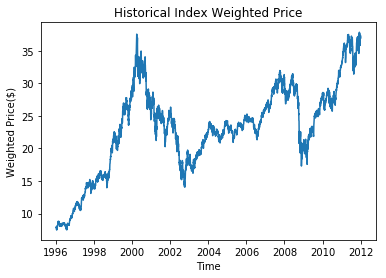

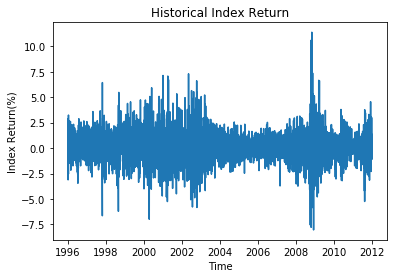

In [21]:
    ret_AllStock_p2 = ret_AllStock.loc[start_dt_training:end_dt_training_p2,:]
    ret_Idx_p2 = np.dot(ret_AllStock_p2,wts_AllStock)
    
    date=ret_AllStock_p2.index.values
    ret_Idx_p2=pd.DataFrame(ret_Idx_p2)
    ret_Idx_p2.index=date
    ret_Idx_p2.columns=['DailyReturn']
    
    # Scale return data by a factor. It seems that the optimizer fails when the values are too close to 0
    scale = 1
    ret_AllStock_p2 = ret_AllStock_p2*scale
    ret_Idx_p2 = ret_Idx_p2*scale

    num_periods, num_stock = ret_AllStock_p2.shape
    
    weight_price_p2=np.dot(Price_AllStock[0:len(ret_AllStock_p2)],wts_AllStock)
   
    plt.plot(date,weight_price_p2)
    plt.xlabel('Time')
    plt.ylabel('Weighted Price($)')
    plt.title('Historical Index Weighted Price')
    plt.show()
    
    plt.plot(date, ret_Idx_p2*100)
    plt.xlabel('Time')
    plt.ylabel('Index Return(%)')
    plt.title('Historical Index Return')
    plt.show()

## Covariance Matrix 

In [30]:
    vols_p2 = ret_AllStock_p2.std()
    rets_mean_p2 = ret_AllStock_p2.mean()
    # demean the returns
    ret_AllStock_p2 = ret_AllStock_p2 - rets_mean_p2   
    # var_ewma calculation of the covraiance using the function from module risk_opt.py
    var_ewma_p2 = riskopt.ewma_cov(ret_AllStock_p2, lamda)
    #var_ewma_annual = var_ewma*252 #Annualize
    # take only the covariance matrix for the last date, which is the forecast for next time period
    cov_end_p2 = var_ewma_p2[-1,:]
    #
    cov_end_annual_p2 = cov_end_p2*252 #Annualize
    std_end_annual_p2 = np.sqrt(np.diag(cov_end_p2))*np.sqrt(252)
    # calculate the correlation matrix
    corr_p2 = ret_AllStock_p2.corr()

## Get Optimized Number of Assets 

<Figure size 432x288 with 0 Axes>

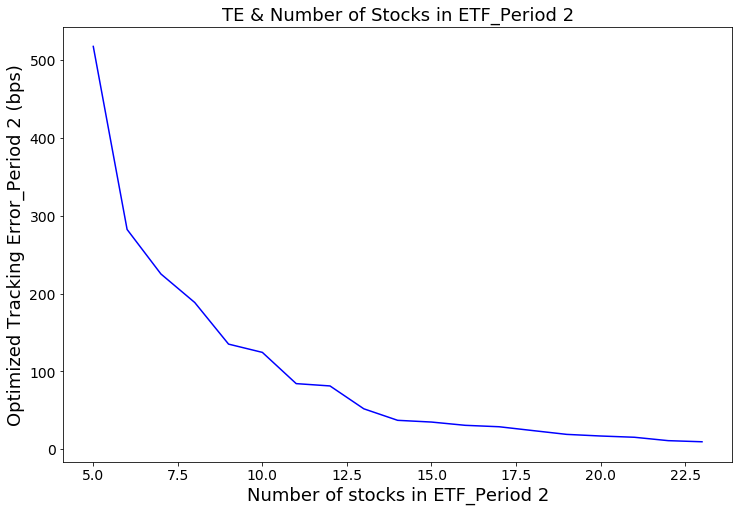

In [32]:
    num_stock_b = 5
    num_stock_e = 24
    numstock_2use_p2= range(num_stock_b,num_stock_e)
    wts_active_hist_p2 = np.zeros([len(numstock_2use_p2), num_stock])
    TE_hist_p2 = np.zeros([len(numstock_2use_p2), 1])
    count = 0

    for i in numstock_2use_p2:
        # only the top weight stocks + no shorting 
        b1_c_a_ = [(0.0,1.0) for j in range(i)] 
        # exclude bottom weighted stocks
        b1_c_b_ = [(0.0,0.0) for j in range(i,num_stock)] 
        b1_curr_ = b1_c_a_ + b1_c_b_
        c1_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) 
        wts_min_curr_p2 = riskopt.opt_min_te(wts_AllStock, cov_end_annual_p2, b1_curr_, c1_)
#        print(wts_min_curr)
        
        wts_active_hist_p2[count,:] = wts_min_curr_p2.transpose()
        TE_optimized_c_p2 = tracking_error(wts_min_curr_p2-wts_AllStock,cov_end_annual_p2)
        TE_hist_p2[count,:] = TE_optimized_c_p2*10000# in bps
        count = count+1
        
        del b1_curr_, b1_c_a_, b1_c_b_,TE_optimized_c_p2,wts_min_curr_p2
    
    figure_count = 1
    plt.figure(figure_count)
    figure_count = figure_count+1
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(range(num_stock_b,num_stock_e), TE_hist_p2,'b')
    plt.xlabel('Number of stocks in ETF_Period 2', fontsize=18)
    plt.ylabel('Optimized Tracking Error_Period 2 (bps)', fontsize=18)
    plt.title('TE & Number of Stocks in ETF_Period 2', fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    

## Find Stock to be Add to ETF

In [33]:
    corr_stock_index_p2=np.zeros((5,2))
    for i in range(11,16):
        xdata=ret_Idx_p2.iloc[:,0]
        ydata=ret_AllStock_p2.iloc[:,i]
        corr=np.corrcoef(xdata, ydata)
        corr_stock_index_p2[i-11,0]=i
        corr_stock_index_p2[i-11,1]=corr[0,1]
#        corr_stock_index.iloc[i,0]=np.correlate(xdata,ydata)
    print(corr_stock_index_p2)
    
    num_stock_add_p2=[]
    for i in range(0,5):
        if corr_stock_index_p2[i,1]>0.50:
            num_stock_add_p2.append(corr_stock_index_p2[i,0])
    
    Ticker_ETF_p2=[]
    for i in range(1,10):
        Ticker_ETF_p2.append(Ticker_AllStock[i])
    for i in range(0,len(num_stock_add_p2)):
        j=num_stock_add_p2[i]
        Ticker_ETF_p2.append(Ticker_AllStock[j])

[[11.          0.60070767]
 [12.          0.50026459]
 [13.          0.49754899]
 [14.          0.39478924]
 [15.          0.43351328]]


## Traning & Testing

In [34]:
    # Calulate Covariance Matrix
    window = 90
    ret_AllStock_total_p2 = ret_AllStock.loc[start_dt_training:end_dt_test_p2,:] # both training and test data for period 1
    datestr_p2 = ret_AllStock_total_p2.index[ret_AllStock_total_p2.index>=start_dt_test_p2]
    qth_previous = datestr_p2[0]-timedelta(days=window)
    wts2 = pd.DataFrame(index=datestr_p2, columns=ret_AllStock_p2.columns)
    
    TE_optimized_All_p2={}
    TE_realized_All_p2={}
    t_begin = start_dt_test_p2
    
    
    
    for t in datestr_p2:
        if t.quarter != qth_previous:

            # update the value of the previous month 
            qth_previous = t.quarter
            # re-balance the portfolio at the start of the month

            ret_used_AllStock = ret_AllStock.loc[start_dt_training:t_begin,:]
            
            t_end_test=t_begin+timedelta(days=window)
            ret_used_test = ret_AllStock.loc[t_begin:t_end_test,:]
            
            vols_used_AllStock = ret_used_AllStock.std()
            rets_used_mean_AllStock = ret_used_AllStock.mean()
            ret_used_AllStock = ret_used_AllStock - rets_used_mean_AllStock
            
            cov_end_realized = ret_used_test.cov()
            cov_end_realized = cov_end_realized.values
            cov_end_annual_realized = cov_end_realized * 252
            # var_ewma calculation of the covraiance using the function from module risk_opt.py
            var_ewma = riskopt.ewma_cov(ret_used_AllStock, lamda)
            #var_ewma_annual = var_ewma*252 #Annualize
            # take only the covariance matrix for the last date, which is the forecast for next time period
            cov_end_ewma = var_ewma[-1,:]
            #
            cov_end_annual_ewma = cov_end_ewma * 252#Annualize
            std_end_annual_ewma = np.sqrt(np.diag(cov_end_ewma))*np.sqrt(252)
            corr_used_AllStock = ret_used_AllStock.corr()
            
            # calling the optimization function
            b1a_ = [(0.0,1.0) for i in range(0,13)]
            b1b_ = [(0.0,0.0) for i in range(13,num_stock)]
            

            b_ = b1a_+b1b_
            c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })            
            wts_min_trackingerror = riskopt.opt_min_te(wts_AllStock, cov_end_annual_ewma, b_, c_)
            wts_slice=pd.DataFrame(wts_min_trackingerror,Ticker_AllStock)
            wts_slice=wts_slice.T
            wts2.loc[t]=wts_slice.values
            
            # calc TE achieved
            wts_active1 = wts_min_trackingerror - wts_AllStock
            TE_optimized = tracking_error(wts_active1,cov_end_annual_ewma)
            TE_realized = tracking_error(wts_active1, cov_end_annual_realized)
            TE_optimized_All_p2[t_begin] = TE_optimized
            TE_realized_All_p2[t_begin] = TE_realized
            
            t_begin = t + timedelta(days=window)
#            print(t_begin)
            
            del corr_used_AllStock, wts_slice
                    
        else:
            # keep the same portfolio weights within the month
            wts2.loc[t] = wts2.iloc[wts2.index.get_loc(t)-1]
            TE_optimized_All_p2[t] = TE_optimized
            TE_realized_All_p2[t] = TE_realized
                
    
    TE_optimized_All_p2 = pd.DataFrame(TE_optimized_All_p2, index=[0])
    TE_optimized_All_p2 = TE_optimized_All_p2.T
    TE_optimized_All_p2.columns = ['TE_optimized']

    TE_realized_All_p2 = pd.DataFrame(TE_realized_All_p2, index=[0])
    TE_realized_All_p2 = TE_realized_All_p2.T
    TE_realized_All_p2.colums = ['TE_realiezed']
    

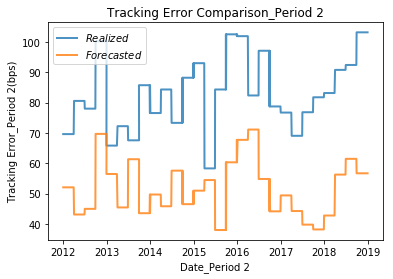

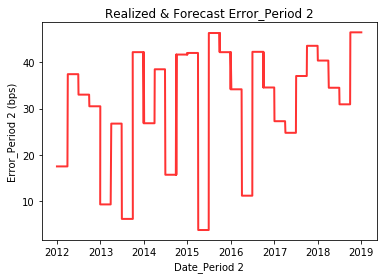

<Figure size 432x288 with 0 Axes>

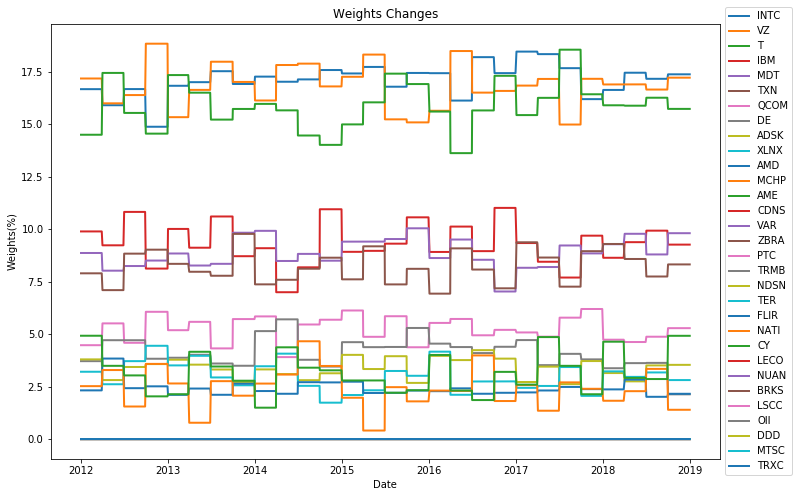

Text(0.5, 1.0, 'Optimized Weight_Period 2')

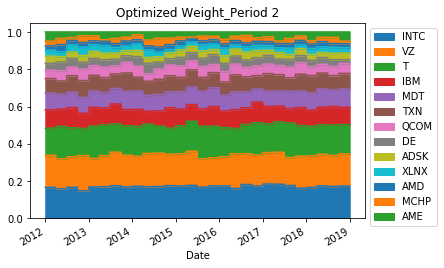

In [35]:
    date_p2=TE_optimized_All_p2.index
    realized_p2 = TE_realized_All_p2.iloc[:,0]*10000
    forecasted_p2 = TE_optimized_All_p2.iloc[:,0]*10000
    
    plt.plot(date_p2,realized_p2,linewidth=2,label='$Realized$',alpha=0.8)
    plt.legend()
    plt.plot(date_p2,forecasted_p2,linewidth=2,label='$Forecasted$',alpha=0.8)
    plt.legend()
    plt.title('Tracking Error Comparison_Period 2')
    plt.xlabel('Date_Period 2')
    plt.ylabel('Tracking Error_Period 2(bps)')
    plt.show()
    
    error_p2 = realized_p2 - forecasted_p2
    plt.plot(date_p2,error_p2,linewidth=2,color='r',label='$Error$',alpha=0.8)
    plt.title('Realized & Forecast Error_Period 2')
    plt.xlabel('Date_Period 2')
    plt.ylabel('Error_Period 2 (bps)')
    plt.show()
    
    plt.figure(figure_count)
    figure_count = figure_count+1
    fig, ax = plt.subplots(figsize=(12,8))
    wts_date = wts2.index.tolist()
    wts_date = pd.DataFrame(wts_date)
    for i in range(0,31):
        label=Ticker_AllStock[i+1]
        plt.plot(wts_date,wts2.iloc[:,i]*100,linewidth=2,label=label)
    plt.legend(loc='UpperRight', bbox_to_anchor=(1,1.05))
    plt.title('Weights Changes')
    plt.xlabel('Date')
    plt.ylabel('Weights(%)')
    plt.show()
    
    wts_DropZero_p2=wts2.loc[:, (wts2 != 0).any(axis=0)]  
    wts_DropZero_p2.plot.area()
    plt.legend(loc='UpperRight', bbox_to_anchor=(1,1))
    plt.title('Optimized Weight_Period 2')
    

## Combine Two Periods

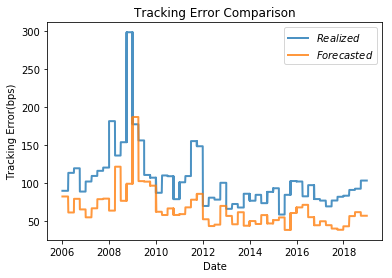

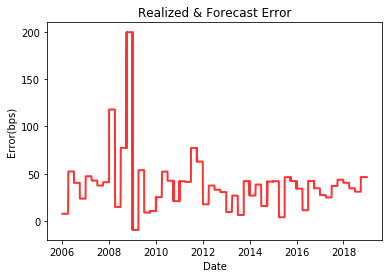

<Figure size 432x288 with 0 Axes>

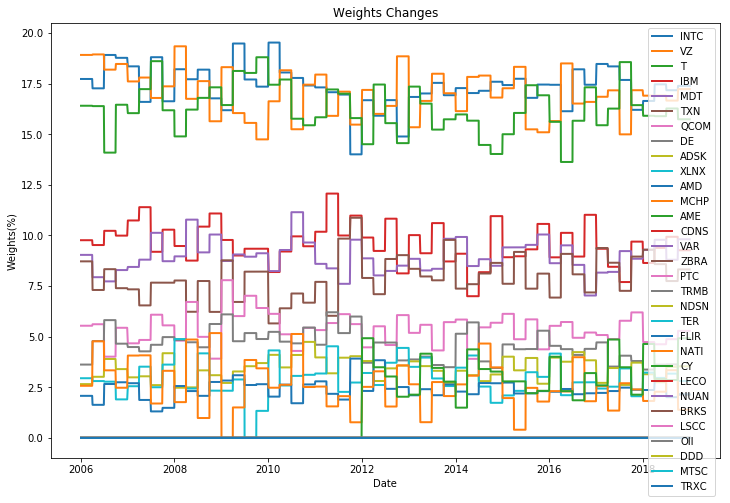

In [36]:
    realized = realized_p1.append(realized_p2)
    forecasted = forecasted_p1.append(forecasted_p2)
    date = date_p1.append(date_p2)
  
    plt.plot(date,realized,linewidth=2,label='$Realized$',alpha=0.8)
    plt.legend()
    plt.plot(date,forecasted,linewidth=2,label='$Forecasted$',alpha=0.8)
    plt.legend()
    plt.title('Tracking Error Comparison')
    plt.xlabel('Date')
    plt.ylabel('Tracking Error(bps)')
    plt.show()
    
    error = realized - forecasted
    plt.plot(date,error,linewidth=2,color='r',label='$Error$',alpha=0.8)
    plt.title('Realized & Forecast Error')
    plt.xlabel('Date')
    plt.ylabel('Error(bps)')
    plt.show()
    
    plt.figure(figure_count)
    figure_count = figure_count+1
    fig, ax = plt.subplots(figsize=(12,8))
    wts_all = wts1.append(wts2)
    wts_date = wts_all.index.tolist()
    wts_date = pd.DataFrame(wts_date)
    for i in range(0,31):
        label=Ticker_AllStock[i+1]
        plt.plot(wts_date,wts_all.iloc[:,i]*100,linewidth=2,label=label)
    plt.legend()
    plt.title('Weights Changes')
    plt.xlabel('Date')
    plt.ylabel('Weights(%)')
    plt.show()
    